In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import random

import warnings
import cmdstanpy
from cmdstanpy import CmdStanModel

import arviz as az
import scipy.stats as stats
# warnings.filterwarnings('ignore')

c:\Users\Julia\anaconda3\envs\studia\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Reading data from a concatenated file

In [2]:
# Read from excel file
df_ac  = pd.read_excel("data.xlsx", sheet_name="Raw_data")

# Select only essential columns
df = df_ac[['Year', 'Married', 'Income per member', "Mean age", "Household", "Total"]]

##### Data splitting

In [3]:
# All data for testing purposes
df_all = df

# Selection of years - 5 years are left for checking results
df = df[:25]

# Quick look at the table
df.head()

,Year,Married,Income per member,Mean age,Household,Total
0,1993,114601,15500,25.50,96391,197254
1,1994,115253,16300,25.60,97107,200800
2,1995,116554,16940,25.70,98990,202732
3,1996,116561,17850,25.95,99627,204624
4,1997,116752,18940,25.90,101018,207235


##### Preliminary data analysis

In [4]:
# Data for models
df.describe()

,Year,Married,Income per member,Mean age,Household,Total
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,2005.000000,125517.720000,24412.000000,26.690000,112143.720000,229046.720000
std,7.359801,6685.028917,5173.445821,0.941962,9520.963469,19449.196392
min,1993.000000,114601.000000,15500.000000,25.500000,96391.000000,197254.000000
25%,1999.000000,119040.000000,21060.000000,25.950000,103874.000000,211676.000000
50%,2005.000000,127142.000000,24670.000000,26.350000,113343.000000,230272.000000
75%,2011.000000,130767.000000,27330.000000,27.400000,119927.000000,245275.000000
max,2017.000000,135749.000000,34640.000000,28.450000,126224.000000,259063.000000


In [5]:
# Data for checking purposes
df_all[25:].describe()

,Year,Married,Income per member,Mean age,Household,Total
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,2020.000000,136807.400000,39212.000000,29.120000,129012.400000,265193.600000
std,1.581139,922.352319,2530.784463,0.270647,1358.823866,2669.521923
min,2018.000000,135704.000000,35700.000000,28.800000,127586.000000,262058.000000
25%,2019.000000,136297.000000,38410.000000,28.900000,128451.000000,263457.000000
50%,2020.000000,136506.000000,38760.000000,29.150000,128579.000000,264696.000000
75%,2021.000000,137758.000000,40860.000000,29.300000,129244.000000,267174.000000
max,2022.000000,137772.000000,42330.000000,29.450000,131202.000000,268583.000000


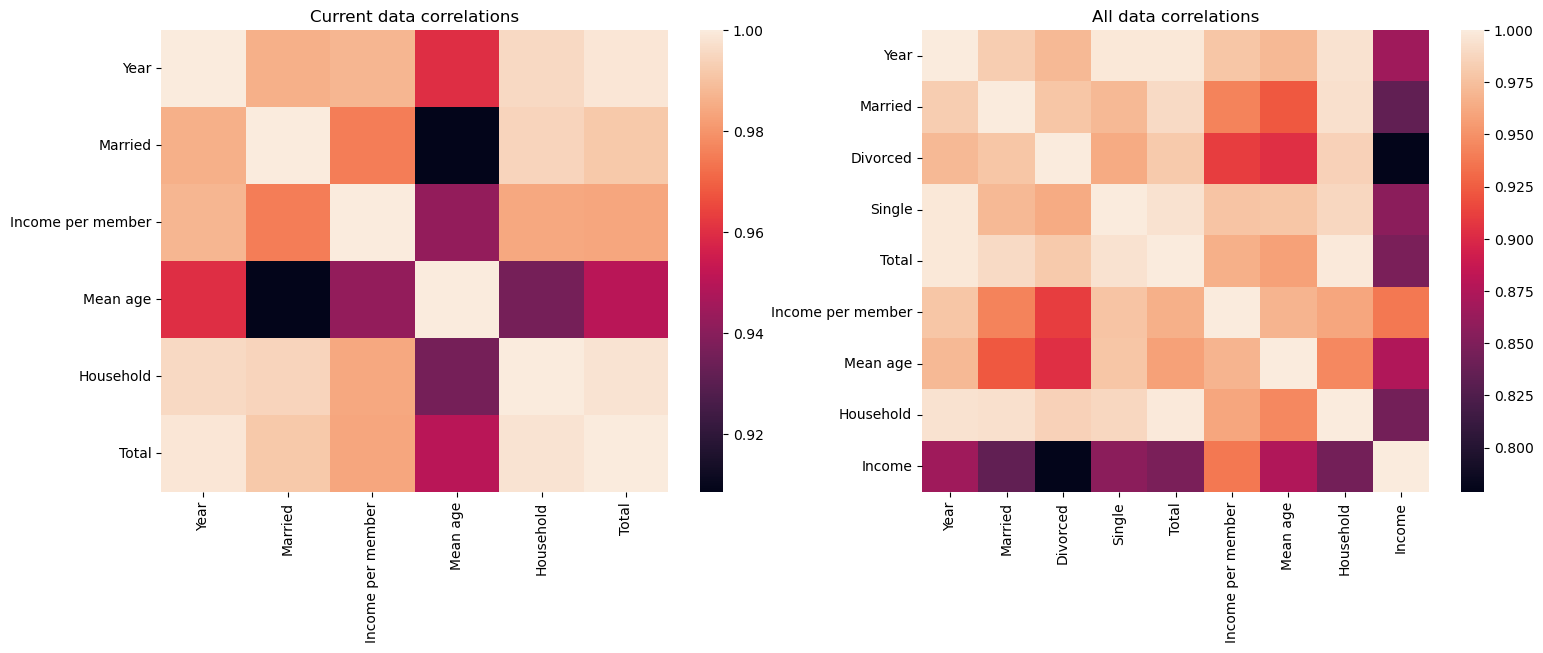

In [6]:
# Correlations

fig, ax = plt.subplots(1,2)

fig.set_size_inches(18, 6)

ax[0].set_title('Current data correlations')
sns.heatmap(df.corr(method="pearson"), ax=ax[0])

ax[1].set_title('All data correlations')
sns.heatmap(df_ac.corr(method="pearson"), ax=ax[1])

plt.show()


##### Notice
The data we selected are strongly correlated with each other (over 90% correlation). High correlation typically means values in one column can be predicted from another, suggesting redundancy or collinearity. It is recommended to avoid having correlated features in your dataset. Indeed, a group of highly correlated features will not bring additional information (or just very few), but will increase the complexity of the algorithm, thus increasing the risk of errors.
Using highly correlated predictors in techniques like linear regression can result in highly unstable models, numerical errors, and very poor prediction performance.

Solution: Remove Redundant Predictors (doesn't make sense)
- Principal Component Analysis (PCA)

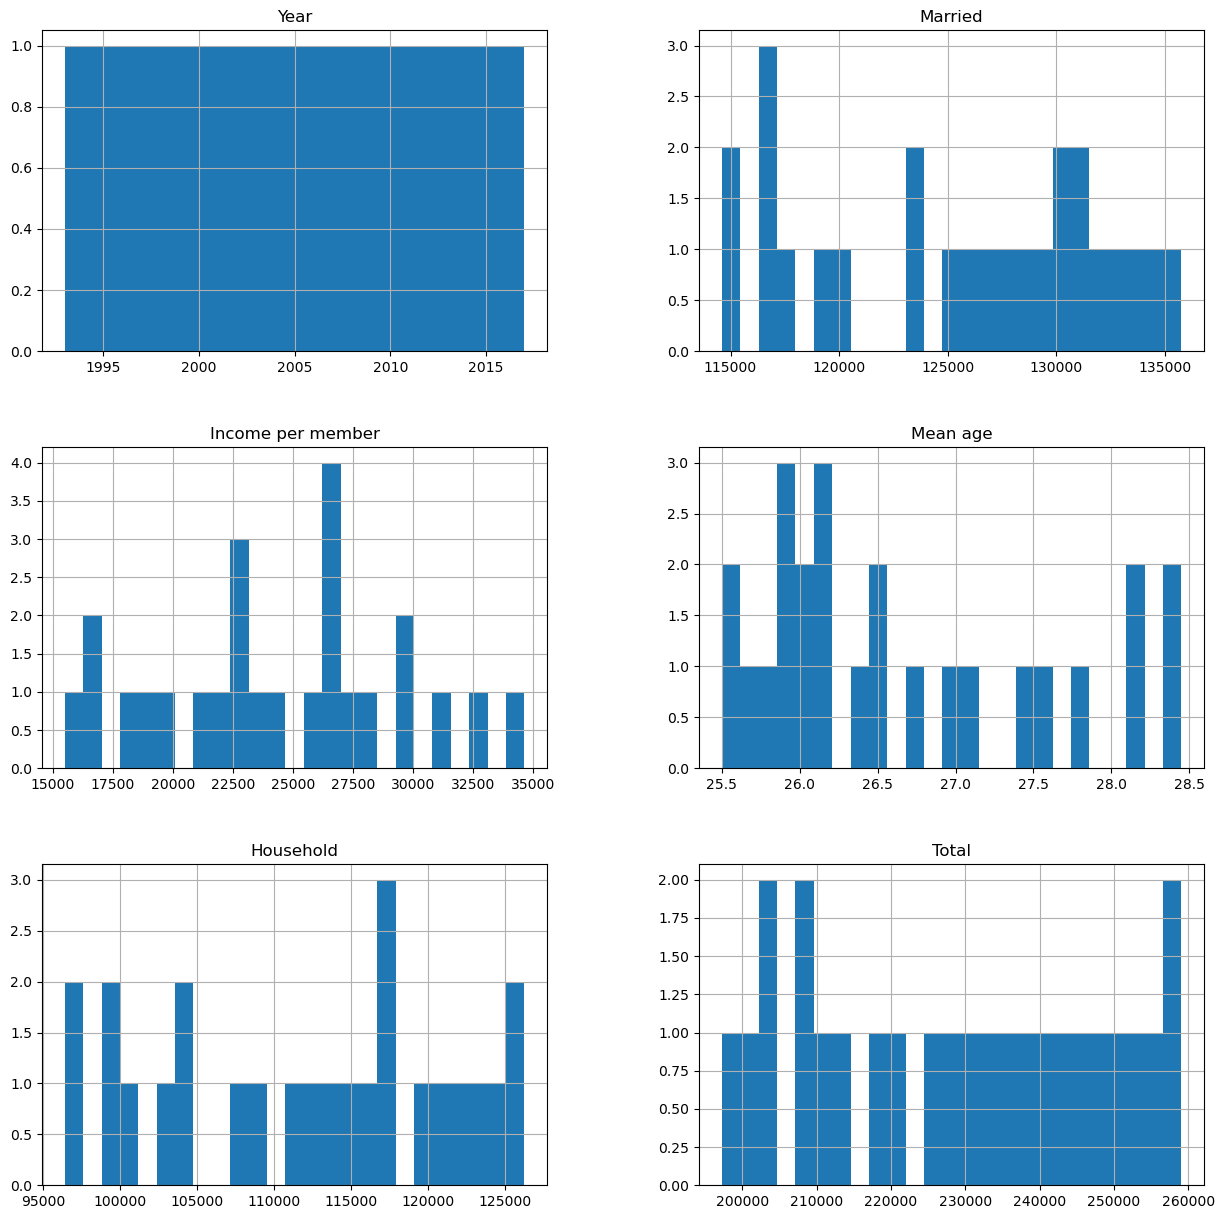

In [7]:
# Data overview
df.hist(figsize=(15,15), bins=25)
plt.show()

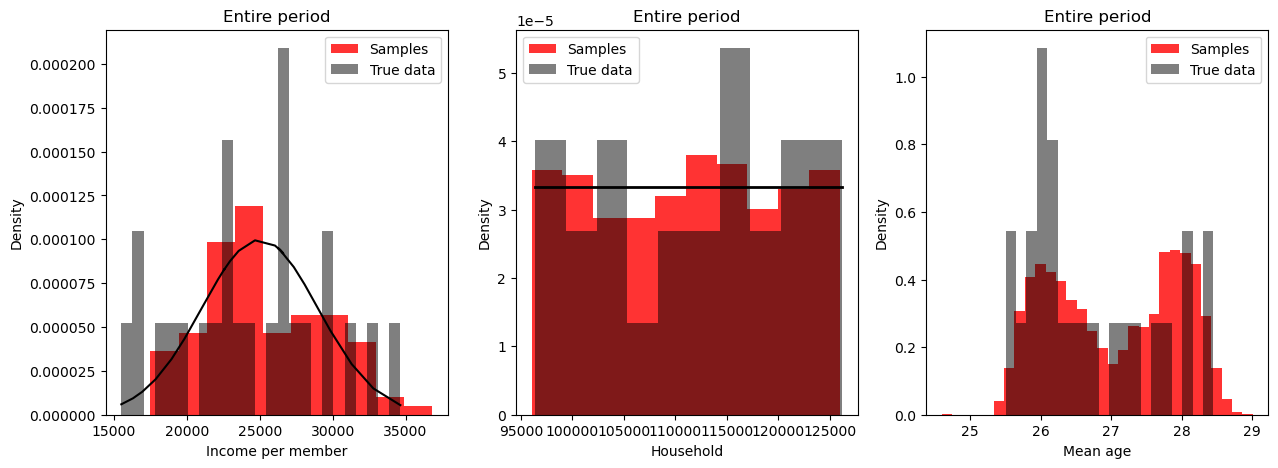

In [8]:
# Histograms of data

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sim = random.normal(25000, 4000, 100) # mu, sigma, samples
plt.plot(df['Income per member'], stats.norm.pdf(df['Income per member'], 25000, 4000), c='k')
plt.hist(sim, color='red', alpha = 0.8, density=True, label="Samples")
plt.hist(df['Income per member'], color='black',bins=25, alpha = 0.5, density=True, label="True data")
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Income per member')
plt.legend()

plt.subplot(1,3,2)
sim = random.uniform(96000, 126000, 1000) # a - from, b - to, samples
# 1/(a-b) - height
plt.plot(df['Household'], [1/(126000-96000)]*len(df['Household']), linewidth=2, color='k')
plt.hist(sim, color='red', alpha = 0.8, density=True, label="Samples")
plt.hist(df['Household'], color='black',bins=10, alpha = 0.5, density=True, label="True data")
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Household')
plt.legend()

plt.subplot(1,3,3)
sim = random.uniform(96000, 126000, 1000)
s = np.random.lognormal(0.15, 0.38, 1000) + 25
d = -np.random.lognormal(0.09, 0.4, 1000)+ 29

X = np.concatenate([s,d])
plt.hist(X, color='red', alpha = 0.8, density=True, bins=30, label="Samples")
plt.hist(df['Mean age'], color='black', bins=20, alpha = 0.5, density=True, label="True data")
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Mean age')
plt.legend()
plt.show()

### 3. Model creation

In [9]:
# Creating models

N = 25
R = 100

model_1_prior = CmdStanModel(stan_file='prior.stan')
model_1_posterior = CmdStanModel(stan_file='posterior.stan')

### 4. Priors

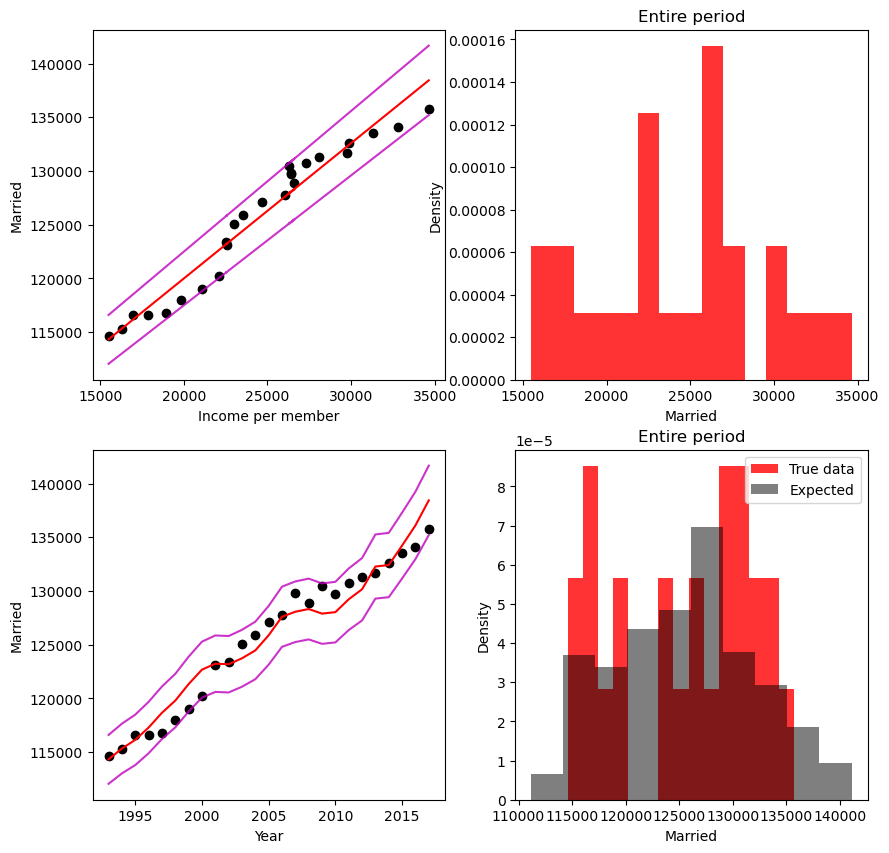

In [10]:
# Parameters testing for Model 1

A = np.column_stack([ np.ones_like(df['Income per member']), df['Income per member']])

# Parameter match - function modelling
a, b = np.linalg.lstsq(A, df['Married'], rcond=None)[0]

# Best selection of parameters
alpha = 1.26
beta = 94800
sigma = 1000

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)

plt.scatter(df['Income per member'], df['Married'], color='black')
plt.plot(df['Income per member'], alpha*df['Income per member'] + beta, color='red')

plt.plot(df['Income per member'], (alpha-0.05)*df['Income per member'] + (beta-1500), alpha = 0.8, color='m')
plt.plot(df['Income per member'], (alpha+0.05)*df['Income per member'] + (beta+1500), alpha = 0.8, color='m')


plt.xlabel('Income per member')
plt.ylabel('Married')


plt.subplot(2,2,2)
plt.hist(df['Income per member'], color='red', alpha = 0.8, bins=15, density=True)

plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')


plt.subplot(2,2,3)
plt.scatter(df['Year'], df['Married'], color='black')

plt.plot(df['Year'], (alpha-0.05)*df['Income per member'] + (beta-1500), alpha = 0.8, color='m')
plt.plot(df['Year'], (alpha+0.05)*df['Income per member'] + (beta+1500), alpha = 0.8, color='m')

plt.plot(df['Year'], alpha*df['Income per member'] + beta, color='red')
plt.xlabel('Year')
plt.ylabel('Married')


plt.subplot(2,2,4)
sim = random.normal(alpha*df['Income per member'] + beta, sigma, (100,25))

plt.hist(df['Married'], color='red',bins=15, alpha = 0.8, density=True)
plt.hist(sim.flatten().tolist(), color='black', alpha = 0.5, density=True)
plt.legend(["True data", "Expected"])
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')

plt.show()

#### 4.1. Model 1.

In [11]:
# Setting data
data = {'N': N, 'income': df['Income per member']}

# creating prior for Model 1
prior_1 = model_1_prior.sample(
                    data=data,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

14:24:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


14:24:30 - cmdstanpy - INFO - CmdStan done processing.


In [12]:
prior_1.draws_pd()

,lp__,accept_stat__,alpha,beta,sigma,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],...,y_sim[16],y_sim[17],y_sim[18],y_sim[19],y_sim[20],y_sim[21],y_sim[22],y_sim[23],y_sim[24],y_sim[25]
0,0.0,0.0,1.39541,95965.8,363.866,117641.0,118205.0,119694.0,121310.0,123219.0,...,133201.0,132597.0,132819.0,134335.0,135459.0,137393.0,137668.0,139021.0,141757.0,144066.0
1,0.0,0.0,1.31904,94585.6,920.009,115618.0,116481.0,114319.0,119083.0,120051.0,...,129924.0,127965.0,128886.0,130385.0,132314.0,134090.0,134564.0,134769.0,137831.0,140274.0
2,0.0,0.0,1.32074,95939.3,1369.850,118025.0,119129.0,119395.0,120566.0,118716.0,...,129258.0,131617.0,133192.0,131577.0,130381.0,135740.0,135535.0,135992.0,140704.0,141658.0
3,0.0,0.0,1.27851,93917.6,1448.920,114407.0,113572.0,115352.0,113999.0,116686.0,...,126430.0,127360.0,129535.0,128749.0,129187.0,130304.0,130324.0,135987.0,135567.0,137973.0
4,0.0,0.0,1.29026,95390.9,1441.340,112325.0,116740.0,113999.0,117546.0,118565.0,...,128488.0,129924.0,130377.0,131357.0,129797.0,135208.0,134845.0,134200.0,139138.0,140197.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,1.31033,94430.7,532.655,114351.0,115648.0,116806.0,118602.0,119131.0,...,128824.0,129325.0,128700.0,130701.0,131043.0,133783.0,133867.0,134757.0,136749.0,139112.0
96,0.0,0.0,1.22993,95747.7,809.024,115040.0,117460.0,115017.0,116284.0,119614.0,...,127486.0,128632.0,128578.0,128741.0,129549.0,132029.0,132914.0,133563.0,136398.0,138342.0
97,0.0,0.0,1.32200,94757.8,1203.580,115430.0,117106.0,117174.0,120095.0,117182.0,...,130557.0,130432.0,130465.0,130598.0,132245.0,134293.0,134099.0,135852.0,138473.0,139727.0
98,0.0,0.0,1.21926,93646.4,504.891,112591.0,114202.0,115266.0,116211.0,116792.0,...,126088.0,125178.0,126235.0,127169.0,127822.0,129899.0,129907.0,132067.0,133500.0,135687.0


##### Prior predictive checks for parameters

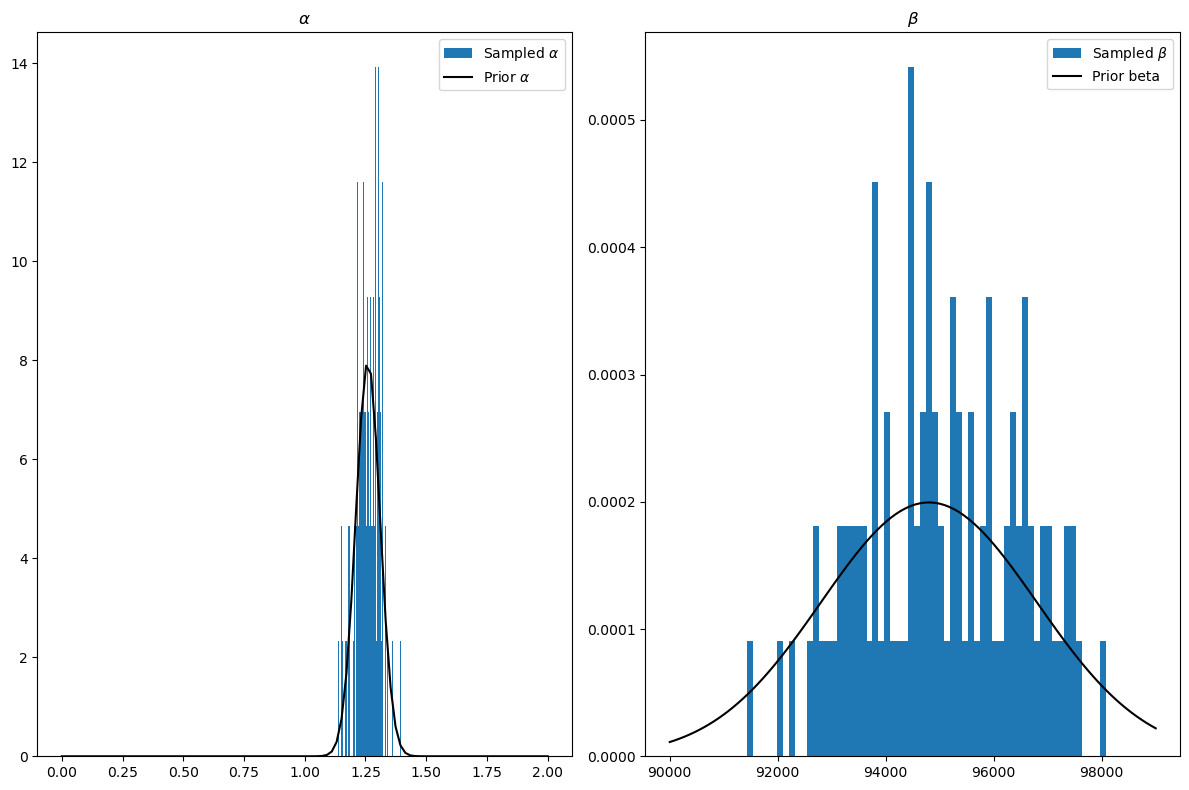

In [13]:
alpha_pred = prior_1.stan_variable('alpha')
beta_pred= prior_1.stan_variable('beta')

fig,axes = plt.subplots(1,2,figsize = (12,8), tight_layout=True)
x = np.linspace(0,2,100)
y = stats.norm.pdf(x=x,loc=1.26, scale=0.05)
axes[0].hist(alpha_pred, bins=60,label=r'Sampled $\alpha$',density=True)
axes[0].set_title(r'$\alpha$')
axes[0].plot(x,y,label=r'Prior $\alpha$',color='k')
axes[0].legend()

x = np.linspace(90000, 99000, 100)
y = stats.norm.pdf(x=x,loc=94800, scale=2000)
axes[1].hist(beta_pred, bins=60,label=r'Sampled $\beta$',density=True)
axes[1].set_title(r'$\beta$')
axes[1].plot(x,y,label = 'Prior beta',color='k')
axes[1].legend()
plt.show()

##### Prior predictive checks for measurements

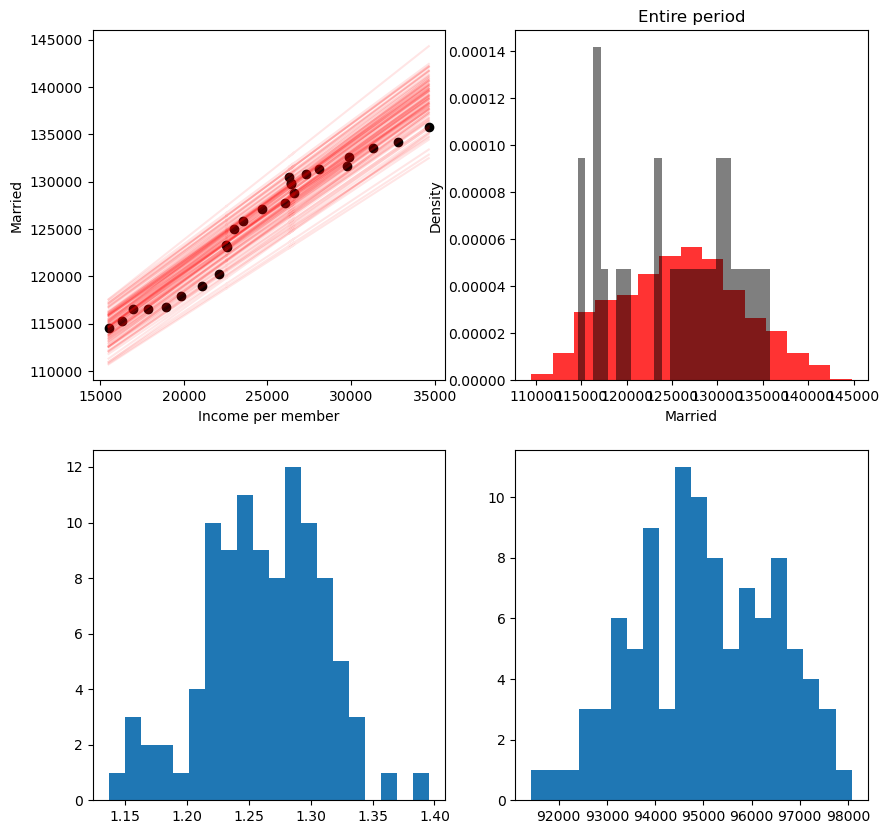

In [14]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
for a, b in zip(prior_1.alpha, prior_1.beta):
    plt.plot(df['Income per member'], a*df['Income per member'] + b, color='red', alpha=0.1)

plt.scatter(df['Income per member'], df['Married'], color='black')
plt.xlabel('Income per member')
plt.ylabel('Married')

plt.subplot(2,2,2)
plt.hist(prior_1.y_sim.flatten().tolist(), bins=15, color='red', alpha = 0.8, density=True)
plt.hist(df['Married'], bins=25, color='black', alpha = 0.5, density=True)
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')

plt.subplot(2,2,3)
plt.hist(prior_1.alpha, bins=20)

plt.subplot(2,2,4)
plt.hist(prior_1.beta, bins=20)

plt.show()

##### POSTERIOR

In [15]:
data = {'N': N, 'income': df['Income per member'], 'y': df['Married']}
post_1 = model_1_posterior.sample(data=data, chains=1, iter_sampling=100)

14:24:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


14:24:32 - cmdstanpy - INFO - CmdStan done processing.


In [16]:
post_1.draws_pd()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma,...,log_lik[16],log_lik[17],log_lik[18],log_lik[19],log_lik[20],log_lik[21],log_lik[22],log_lik[23],log_lik[24],log_lik[25]
0,-189.111,0.921364,0.245106,2.0,7.0,0.0,191.201,1.26242,95033.1,1691.64,...,-8.36156,-9.23634,-8.68822,-8.61763,-8.48189,-8.50481,-8.35601,-8.52113,-9.26284,-9.93981
1,-188.692,0.887147,0.245106,3.0,15.0,0.0,191.039,1.25512,94961.4,1201.25,...,-8.09492,-10.19760,-8.95405,-8.79301,-8.45832,-8.15429,-8.01741,-8.17152,-9.35719,-10.51690
2,-188.909,1.000000,0.245106,3.0,7.0,0.0,188.976,1.25545,94813.3,1177.05,...,-8.13484,-10.52790,-9.14593,-8.96301,-8.57749,-8.08246,-8.01880,-8.09686,-9.20429,-10.34210
3,-188.940,0.821777,0.245106,4.0,15.0,0.0,189.907,1.23887,94959.1,1641.84,...,-8.48277,-9.92766,-9.12612,-9.02747,-8.79484,-8.32723,-8.39687,-8.32798,-8.70538,-9.15979
4,-188.476,0.878919,0.245106,3.0,11.0,0.0,191.261,1.26116,94420.2,1343.58,...,-8.33433,-10.44380,-9.26629,-9.10040,-8.75289,-8.14430,-8.19315,-8.15226,-8.85654,-9.66154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-187.831,0.900344,0.245106,2.0,7.0,0.0,188.994,1.26291,94838.0,1411.47,...,-8.21369,-9.65481,-8.78863,-8.67281,-8.44383,-8.31389,-8.17166,-8.33324,-9.28227,-10.19030
96,-188.080,0.989632,0.245106,3.0,15.0,0.0,188.341,1.27551,94496.3,1314.86,...,-8.15080,-9.82513,-8.82033,-8.67621,-8.40732,-8.27943,-8.10043,-8.31223,-9.46892,-10.58490
97,-187.800,0.951834,0.245106,2.0,5.0,0.0,188.472,1.27152,94539.9,1378.47,...,-8.20829,-9.79660,-8.85491,-8.72131,-8.46523,-8.28091,-8.14925,-8.30548,-9.29486,-10.26450
98,-188.358,0.985896,0.245106,3.0,7.0,0.0,188.520,1.25921,94833.2,1233.54,...,-8.12344,-10.14530,-8.95382,-8.79526,-8.47166,-8.17067,-8.04414,-8.18968,-9.32197,-10.43800


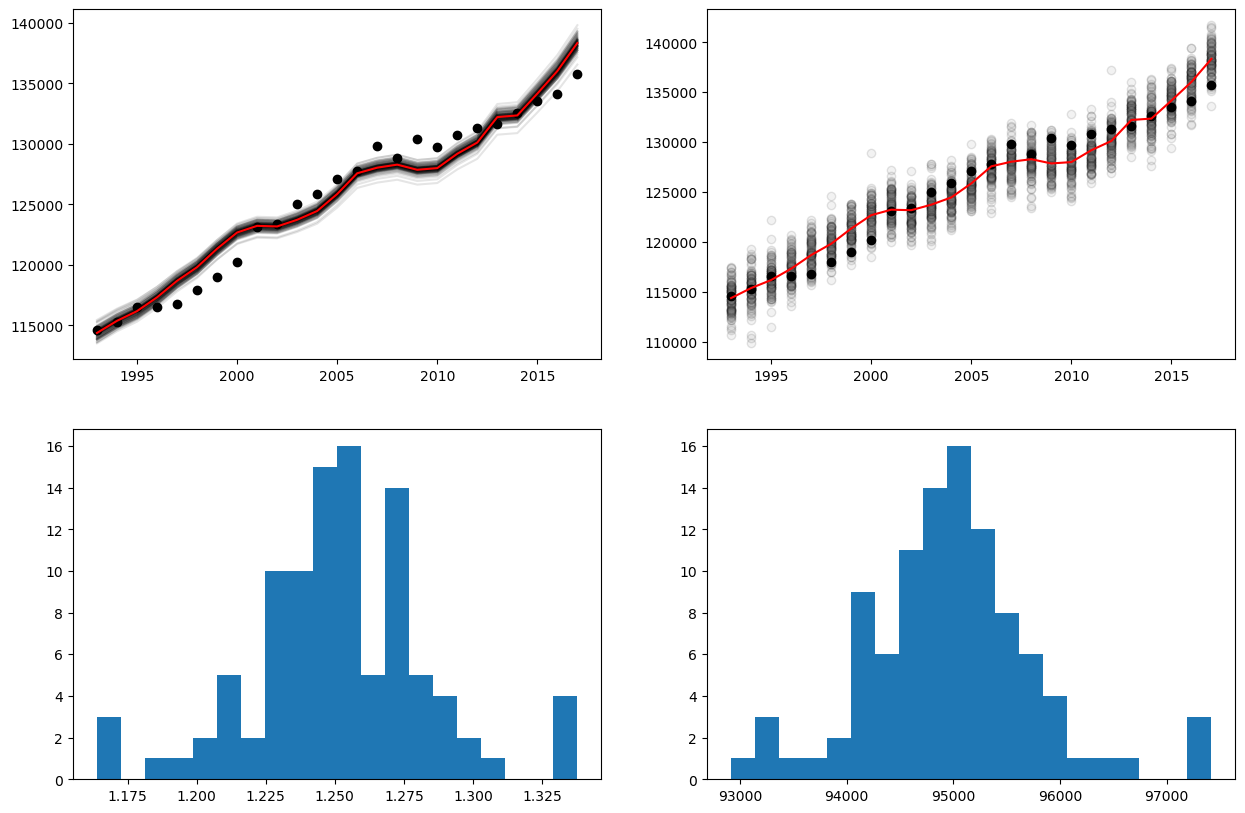

In [17]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
for i in range(len(post_1.y_sim)):
    plt.plot(df['Year'], post_1.alpha[i]*df['Income per member'] + post_1.beta[i], color='black', alpha = 0.1)
plt.plot(df['Year'], post_1.alpha.mean()*df['Income per member'] + post_1.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.subplot(2,2,2)
for i in range(len(post_1.y_sim)):
    plt.scatter(df['Year'], post_1.y_sim[i], color='gray', alpha = 0.1,edgecolors= "black")
plt.plot(df['Year'], post_1.alpha.mean()*df['Income per member'] + post_1.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')


plt.subplot(2,2,3)
plt.hist(post_1.alpha, bins=20)

plt.subplot(2,2,4)
plt.hist(post_1.beta, bins=20)

plt.show()
plt.show()